### Stable Video Diffusion OpenVino
https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/stable-video-diffusion/stable-video-diffusion.ipynb




In [1]:

%pip install -q "torch>=2.1" "diffusers>=0.25" "peft>=0.6.2" "transformers" "openvino>=2024.1.0" Pillow opencv-python tqdm  "gradio>=4.19" safetensors --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q datasets "nncf>=2.10.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.


In [2]:
import torch
from pathlib import Path
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.models.attention_processor import AttnProcessor
from safetensors import safe_open
import gc
import requests
MODEL_DIR = Path("model")

IMAGE_ENCODER_PATH = MODEL_DIR / "image_encoder.xml"
VAE_ENCODER_PATH = MODEL_DIR / "vae_encoder.xml"
VAE_DECODER_PATH = MODEL_DIR / "vae_decoder.xml"
UNET_PATH = MODEL_DIR / "unet.xml"

In [3]:
import torch
from PIL import Image
from pathlib import Path
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.models.attention_processor import AttnProcessor
from safetensors import safe_open
import gc
import requests

lcm_scheduler_url = "https://huggingface.co/spaces/wangfuyun/AnimateLCM-SVD/raw/main/lcm_scheduler.py"

r = requests.get(lcm_scheduler_url)

with open("lcm_scheduler.py", "w") as f:
    f.write(r.text)

from lcm_scheduler import AnimateLCMSVDStochasticIterativeScheduler
from huggingface_hub import hf_hub_download

MODEL_DIR = Path("model")

IMAGE_ENCODER_PATH = MODEL_DIR / "image_encoder.xml"
VAE_ENCODER_PATH = MODEL_DIR / "vae_encoder.xml"
VAE_DECODER_PATH = MODEL_DIR / "vae_decoder.xml"
UNET_PATH = MODEL_DIR / "unet.xml"


load_pt_pipeline = not (VAE_ENCODER_PATH.exists() and VAE_DECODER_PATH.exists() and UNET_PATH.exists() and IMAGE_ENCODER_PATH.exists())

unet, vae, image_encoder = None, None, None
if load_pt_pipeline:
    noise_scheduler = AnimateLCMSVDStochasticIterativeScheduler(
        num_train_timesteps=40,
        sigma_min=0.002,
        sigma_max=700.0,
        sigma_data=1.0,
        s_noise=1.0,
        rho=7,
        clip_denoised=False,
    )
    pipe = StableVideoDiffusionPipeline.from_pretrained(
        "stabilityai/stable-video-diffusion-img2vid-xt",
        variant="fp16",
        scheduler=noise_scheduler,
    )
    pipe.unet.set_attn_processor(AttnProcessor())
    hf_hub_download(
        repo_id="wangfuyun/AnimateLCM-SVD-xt",
        filename="AnimateLCM-SVD-xt.safetensors",
        local_dir="./checkpoints",
    )
    state_dict = {}
    LCM_LORA_PATH = Path(
        "checkpoints/AnimateLCM-SVD-xt.safetensors",
    )
    with safe_open(LCM_LORA_PATH, framework="pt", device="cpu") as f:
        for key in f.keys():
            state_dict[key] = f.get_tensor(key)
    missing, unexpected = pipe.unet.load_state_dict(state_dict, strict=True)

    pipe.scheduler.save_pretrained(MODEL_DIR / "scheduler")
    pipe.feature_extractor.save_pretrained(MODEL_DIR / "feature_extractor")
    unet = pipe.unet
    unet.eval()
    vae = pipe.vae
    vae.eval()
    image_encoder = pipe.image_encoder
    image_encoder.eval()
    del pipe
    gc.collect()

from PIL import Image as PILImage
import os
from pathlib import Path

# Define the path to the upload folder
UPLOAD_FOLDER = 'C:\\Users\\Diya\\Documents\\huggingface_env\\uploads'

# Function to get the most recently uploaded image file
def get_most_recent_image(upload_folder):
    # Get a list of all files in the upload folder
    files = os.listdir(upload_folder)
    # Filter out only image files (optional, if other files may be present)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # If there are image files, sort them by modification time in descending order
    if image_files:
        most_recent_file = max(image_files, key=lambda x: os.path.getmtime(os.path.join(upload_folder, x)))
        return most_recent_file
    else:
        return None

# Get the most recent image file
uploaded_image_name = get_most_recent_image(UPLOAD_FOLDER)

if uploaded_image_name:
    # Load the conditioning image
    uploaded_image_path =uploaded_image_name
    if os.path.exists(uploaded_image_path):
        try:
            image = PILImage.open(uploaded_image_path).convert("RGB")
            image = image.resize((512, 256))  # Resize if needed
            print("Image loaded successfully:", uploaded_image_path)
        except PILImage.UnidentifiedImageError as e:
            print(f"Error loading image: {e}")
    else:
        print(f"Image file not found at {uploaded_image_path}")
else:
    print("No images found in the upload folder.")



#image = Image.open("snow.png").convert("RGB")
#image = image.resize((512, 256))

Image loaded successfully: fountain.png


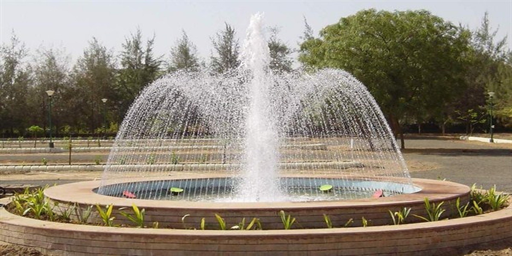

In [4]:
image

In [5]:
#image Encoder 

In [6]:
import openvino as ov


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


if not IMAGE_ENCODER_PATH.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(
            image_encoder,
            example_input=torch.zeros((1, 3, 224, 224)),
            input=[-1, 3, 224, 224],
        )
    ov.save_model(ov_model, IMAGE_ENCODER_PATH)
    del ov_model
    cleanup_torchscript_cache()
    print(f"Image Encoder successfully converted to IR and saved to {IMAGE_ENCODER_PATH}")
del image_encoder
gc.collect();

In [7]:
#UNet

In [8]:
if not UNET_PATH.exists():
    unet_inputs = {
        "sample": torch.ones([2, 2, 8, 32, 32]),
        "timestep": torch.tensor(1.256),
        "encoder_hidden_states": torch.zeros([2, 1, 1024]),
        "added_time_ids": torch.ones([2, 3]),
    }
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=unet_inputs)
    ov.save_model(ov_model, UNET_PATH)
    del ov_model
    cleanup_torchscript_cache()
    print(f"UNet successfully converted to IR and saved to {UNET_PATH}")

del unet
gc.collect();

In [9]:
# VAE Encoder and Decoder

In [10]:
import torch
from pathlib import Path
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.models.attention_processor import AttnProcessor
from safetensors import safe_open
import gc
import requests

class VAEEncoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, image):
        return self.vae.encode(x=image)["latent_dist"].sample()


class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latents, num_frames: int):
        return self.vae.decode(latents, num_frames=num_frames)


if not VAE_ENCODER_PATH.exists():
    vae_encoder = VAEEncoderWrapper(vae)
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=torch.zeros((1, 3, 576, 1024)))
    ov.save_model(ov_model, VAE_ENCODER_PATH)
    cleanup_torchscript_cache()
    print(f"VAE Encoder successfully converted to IR and saved to {VAE_ENCODER_PATH}")
    del vae_encoder
    gc.collect()

if not VAE_DECODER_PATH.exists():
    vae_decoder = VAEDecoderWrapper(vae)
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=(torch.zeros((8, 4, 72, 128)), torch.tensor(8)))
    ov.save_model(ov_model, VAE_DECODER_PATH)
    cleanup_torchscript_cache()
    print(f"VAE Decoder successfully converted to IR and saved to {VAE_ENCODER_PATH}")
    del vae_decoder
    gc.collect()

del vae
gc.collect();

In [11]:
# Pipeline

In [12]:
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
import PIL.Image
from diffusers.image_processor import VaeImageProcessor
from diffusers.utils.torch_utils import randn_tensor
from typing import Callable, Dict, List, Optional, Union
from diffusers.pipelines.stable_video_diffusion import (
    StableVideoDiffusionPipelineOutput,
)


def _append_dims(x, target_dims):
    """Appends dimensions to the end of a tensor until it has target_dims dimensions."""
    dims_to_append = target_dims - x.ndim
    if dims_to_append < 0:
        raise ValueError(f"input has {x.ndim} dims but target_dims is {target_dims}, which is less")
    return x[(...,) + (None,) * dims_to_append]


def tensor2vid(video: torch.Tensor, processor, output_type="np"):
    # Based on:
    # https://github.com/modelscope/modelscope/blob/1509fdb973e5871f37148a4b5e5964cafd43e64d/modelscope/pipelines/multi_modal/text_to_video_synthesis_pipeline.py#L78

    batch_size, channels, num_frames, height, width = video.shape
    outputs = []
    for batch_idx in range(batch_size):
        batch_vid = video[batch_idx].permute(1, 0, 2, 3)
        batch_output = processor.postprocess(batch_vid, output_type)

        outputs.append(batch_output)

    return outputs


class OVStableVideoDiffusionPipeline(DiffusionPipeline):
    r"""
    Pipeline to generate video from an input image using Stable Video Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
        image_encoder ([`~transformers.CLIPVisionModelWithProjection`]):
            Frozen CLIP image-encoder ([laion/CLIP-ViT-H-14-laion2B-s32B-b79K](https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K)).
        unet ([`UNetSpatioTemporalConditionModel`]):
            A `UNetSpatioTemporalConditionModel` to denoise the encoded image latents.
        scheduler ([`EulerDiscreteScheduler`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents.
        feature_extractor ([`~transformers.CLIPImageProcessor`]):
            A `CLIPImageProcessor` to extract features from generated images.
    """

    def __init__(
        self,
        vae_encoder,
        image_encoder,
        unet,
        vae_decoder,
        scheduler,
        feature_extractor,
    ):
        super().__init__()
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder
        self.image_encoder = image_encoder
        self.register_to_config(unet=unet)
        self.scheduler = scheduler
        self.feature_extractor = feature_extractor
        self.vae_scale_factor = 2 ** (4 - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)

    def _encode_image(self, image, device, num_videos_per_prompt, do_classifier_free_guidance):
        dtype = torch.float32

        if not isinstance(image, torch.Tensor):
            image = self.image_processor.pil_to_numpy(image)
            image = self.image_processor.numpy_to_pt(image)

            # We normalize the image before resizing to match with the original implementation.
            # Then we unnormalize it after resizing.
            image = image * 2.0 - 1.0
            image = _resize_with_antialiasing(image, (224, 224))
            image = (image + 1.0) / 2.0

            # Normalize the image with for CLIP input
            image = self.feature_extractor(
                images=image,
                do_normalize=True,
                do_center_crop=False,
                do_resize=False,
                do_rescale=False,
                return_tensors="pt",
            ).pixel_values

        image = image.to(device=device, dtype=dtype)
        image_embeddings = torch.from_numpy(self.image_encoder(image)[0])
        image_embeddings = image_embeddings.unsqueeze(1)

        # duplicate image embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = image_embeddings.shape
        image_embeddings = image_embeddings.repeat(1, num_videos_per_prompt, 1)
        image_embeddings = image_embeddings.view(bs_embed * num_videos_per_prompt, seq_len, -1)

        if do_classifier_free_guidance:
            negative_image_embeddings = torch.zeros_like(image_embeddings)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            image_embeddings = torch.cat([negative_image_embeddings, image_embeddings])
        return image_embeddings

    def _encode_vae_image(
        self,
        image: torch.Tensor,
        device,
        num_videos_per_prompt,
        do_classifier_free_guidance,
    ):
        image_latents = torch.from_numpy(self.vae_encoder(image)[0])

        if do_classifier_free_guidance:
            negative_image_latents = torch.zeros_like(image_latents)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            image_latents = torch.cat([negative_image_latents, image_latents])

        # duplicate image_latents for each generation per prompt, using mps friendly method
        image_latents = image_latents.repeat(num_videos_per_prompt, 1, 1, 1)

        return image_latents

    def _get_add_time_ids(
        self,
        fps,
        motion_bucket_id,
        noise_aug_strength,
        dtype,
        batch_size,
        num_videos_per_prompt,
        do_classifier_free_guidance,
    ):
        add_time_ids = [fps, motion_bucket_id, noise_aug_strength]

        passed_add_embed_dim = 256 * len(add_time_ids)
        expected_add_embed_dim = 3 * 256

        if expected_add_embed_dim != passed_add_embed_dim:
            raise ValueError(
                f"Model expects an added time embedding vector of length {expected_add_embed_dim}, but a vector of {passed_add_embed_dim} was created. The model has an incorrect config. Please check `unet.config.time_embedding_type` and `text_encoder_2.config.projection_dim`."
            )

        add_time_ids = torch.tensor([add_time_ids], dtype=dtype)
        add_time_ids = add_time_ids.repeat(batch_size * num_videos_per_prompt, 1)

        if do_classifier_free_guidance:
            add_time_ids = torch.cat([add_time_ids, add_time_ids])

        return add_time_ids

    def decode_latents(self, latents, num_frames, decode_chunk_size=14):
        # [batch, frames, channels, height, width] -> [batch*frames, channels, height, width]
        latents = latents.flatten(0, 1)

        latents = 1 / 0.18215 * latents

        # decode decode_chunk_size frames at a time to avoid OOM
        frames = []
        for i in range(0, latents.shape[0], decode_chunk_size):
            frame = torch.from_numpy(self.vae_decoder([latents[i : i + decode_chunk_size], num_frames])[0])
            frames.append(frame)
        frames = torch.cat(frames, dim=0)

        # [batch*frames, channels, height, width] -> [batch, channels, frames, height, width]
        frames = frames.reshape(-1, num_frames, *frames.shape[1:]).permute(0, 2, 1, 3, 4)

        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        frames = frames.float()
        return frames

    def check_inputs(self, image, height, width):
        if not isinstance(image, torch.Tensor) and not isinstance(image, PIL.Image.Image) and not isinstance(image, list):
            raise ValueError("`image` has to be of type `torch.FloatTensor` or `PIL.Image.Image` or `List[PIL.Image.Image]` but is" f" {type(image)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

    def prepare_latents(
        self,
        batch_size,
        num_frames,
        num_channels_latents,
        height,
        width,
        dtype,
        device,
        generator,
        latents=None,
    ):
        shape = (
            batch_size,
            num_frames,
            num_channels_latents // 2,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    @torch.no_grad()
    def __call__(
        self,
        image: Union[PIL.Image.Image, List[PIL.Image.Image], torch.FloatTensor],
        height: int = 320,
        width: int = 512,
        num_frames: Optional[int] = 8,
        num_inference_steps: int = 4,
        min_guidance_scale: float = 1.0,
        max_guidance_scale: float = 1.2,
        fps: int = 7,
        motion_bucket_id: int = 80,
        noise_aug_strength: int = 0.01,
        decode_chunk_size: Optional[int] = None,
        num_videos_per_prompt: Optional[int] = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        return_dict: bool = True,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:discussed
            image (`PIL.Image.Image` or `List[PIL.Image.Image]` or `torch.FloatTensor`):
                Image or images to guide image generation. If you provide a tensor, it needs to be compatible with
                [`CLIPImageProcessor`](https://huggingface.co/lambdalabs/sd-image-variations-diffusers/blob/main/feature_extractor/preprocessor_config.json).
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_frames (`int`, *optional*):
                The number of video frames to generate. Defaults to 14 for `stable-video-diffusion-img2vid` and to 25 for `stable-video-diffusion-img2vid-xt`
            num_inference_steps (`int`, *optional*, defaults to 25):


                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference. This parameter is modulated by `strength`.
            min_guidance_scale (`float`, *optional*, defaults to 1.0):
                The minimum guidance scale. Used for the classifier free guidance with first frame.
            max_guidance_scale (`float`, *optional*, defaults to 3.0):
                The maximum guidance scale. Used for the classifier free guidance with last frame.
            fps (`int`, *optional*, defaults to 7):
                Frames per second. The rate at which the generated images shall be exported to a video after generation.
                Note that Stable Diffusion Video's UNet was micro-conditioned on fps-1 during training.
            motion_bucket_id (`int`, *optional*, defaults to 127):
                The motion bucket ID. Used as conditioning for the generation. The higher the number the more motion will be in the video.
            noise_aug_strength (`int`, *optional*, defaults to 0.02):
                The amount of noise added to the init image, the higher it is the less the video will look like the init image. Increase it for more motion.
            decode_chunk_size (`int`, *optional*):
                The number of frames to decode at a time. The higher the chunk size, the higher the temporal consistency
                between frames, but also the higher the memory consumption. By default, the decoder will decode all frames at once
                for maximal quality. Reduce `decode_chunk_size` to reduce memory usage.
            num_videos_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            callback_on_step_end (`Callable`, *optional*):
                A function that calls at the end of each denoising steps during the inference. The function is called
                with the following arguments: `callback_on_step_end(self: DiffusionPipeline, step: int, timestep: int,
                callback_kwargs: Dict)`. `callback_kwargs` will include a list of all tensors as specified by
                `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeline class.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.

        Returns:
            [`~pipelines.stable_diffusion.StableVideoDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableVideoDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list of list with the generated frames.

        Examples:

        ```py
        from diffusers import StableVideoDiffusionPipeline
        from diffusers.utils import load_image, export_to_video

        pipe = StableVideoDiffusionPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16")
        pipe.to("cuda")

        image = load_image("https://lh3.googleusercontent.com/y-iFOHfLTwkuQSUegpwDdgKmOjRSTvPxat63dQLB25xkTs4lhIbRUFeNBWZzYf370g=s1200")
        image = image.resize((1024, 576))

        frames = pipe(image, num_frames=25, decode_chunk_size=8).frames[0]
        export_to_video(frames, "generated.mp4", fps=7)
        ```
        """
        # 0. Default height and width to unet
        height = height or 96 * self.vae_scale_factor
        width = width or 96 * self.vae_scale_factor

        num_frames = num_frames if num_frames is not None else 25
        decode_chunk_size = decode_chunk_size if decode_chunk_size is not None else num_frames

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(image, height, width)

        # 2. Define call parameters
        if isinstance(image, PIL.Image.Image):
            batch_size = 1
        elif isinstance(image, list):
            batch_size = len(image)
        else:
            batch_size = image.shape[0]
        device = torch.device("cpu")

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = max_guidance_scale > 1.0

        # 3. Encode input image
        image_embeddings = self._encode_image(image, device, num_videos_per_prompt, do_classifier_free_guidance)

        # NOTE: Stable Diffusion Video was conditioned on fps - 1, which
        # is why it is reduced here.
        # See: https://github.com/Stability-AI/generative-models/blob/ed0997173f98eaf8f4edf7ba5fe8f15c6b877fd3/scripts/sampling/simple_video_sample.py#L188
        fps = fps - 1

        # 4. Encode input image using VAE
        image = self.image_processor.preprocess(image, height=height, width=width)
        noise = randn_tensor(image.shape, generator=generator, device=image.device, dtype=image.dtype)
        image = image + noise_aug_strength * noise

        image_latents = self._encode_vae_image(image, device, num_videos_per_prompt, do_classifier_free_guidance)
        image_latents = image_latents.to(image_embeddings.dtype)

        # Repeat the image latents for each frame so we can concatenate them with the noise
        # image_latents [batch, channels, height, width] ->[batch, num_frames, channels, height, width]
        image_latents = image_latents.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)

        # 5. Get Added Time IDs
        added_time_ids = self._get_add_time_ids(
            fps,
            motion_bucket_id,
            noise_aug_strength,
            image_embeddings.dtype,
            batch_size,
            num_videos_per_prompt,
            do_classifier_free_guidance,
        )
        added_time_ids = added_time_ids

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps
        # 5. Prepare latent variables
        num_channels_latents = 8
        latents = self.prepare_latents(
            batch_size * num_videos_per_prompt,
            num_frames,
            num_channels_latents,
            height,
            width,
            image_embeddings.dtype,
            device,
            generator,
            latents,
        )

        # 7. Prepare guidance scale
        guidance_scale = torch.linspace(min_guidance_scale, max_guidance_scale, num_frames).unsqueeze(0)
        guidance_scale = guidance_scale.to(device, latents.dtype)
        guidance_scale = guidance_scale.repeat(batch_size * num_videos_per_prompt, 1)
        guidance_scale = _append_dims(guidance_scale, latents.ndim)

        # 8. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # Concatenate image_latents over channels dimention
                latent_model_input = torch.cat([latent_model_input, image_latents], dim=2)
                # predict the noise residual
                noise_pred = torch.from_numpy(
                    self.unet(
                        [
                            latent_model_input,
                            t,
                            image_embeddings,
                            added_time_ids,
                        ]
                    )[0]
                )
                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)

                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        if not output_type == "latent":
            frames = self.decode_latents(latents, num_frames, decode_chunk_size)
            frames = tensor2vid(frames, self.image_processor, output_type=output_type)
        else:
            frames = latents

        if not return_dict:
            return frames

        return StableVideoDiffusionPipelineOutput(frames=frames)


# resizing utils
def _resize_with_antialiasing(input, size, interpolation="bicubic", align_corners=True):
    h, w = input.shape[-2:]
    factors = (h / size[0], w / size[1])

    # First, we have to determine sigma
    # Taken from skimage: https://github.com/scikit-image/scikit-image/blob/v0.19.2/skimage/transform/_warps.py#L171
    sigmas = (
        max((factors[0] - 1.0) / 2.0, 0.001),
        max((factors[1] - 1.0) / 2.0, 0.001),
    )
    # Now kernel size. Good results are for 3 sigma, but that is kind of slow. Pillow uses 1 sigma
    # https://github.com/python-pillow/Pillow/blob/master/src/libImaging/Resample.c#L206
    # But they do it in the 2 passes, which gives better results. Let's try 2 sigmas for now
    ks = int(max(2.0 * 2 * sigmas[0], 3)), int(max(2.0 * 2 * sigmas[1], 3))

    # Make sure it is odd
    if (ks[0] % 2) == 0:
        ks = ks[0] + 1, ks[1]

    if (ks[1] % 2) == 0:
        ks = ks[0], ks[1] + 1

    input = _gaussian_blur2d(input, ks, sigmas)

    output = torch.nn.functional.interpolate(input, size=size, mode=interpolation, align_corners=align_corners)
    return output


def _compute_padding(kernel_size):
    """Compute padding tuple."""
    # 4 or 6 ints:  (padding_left, padding_right,padding_top,padding_bottom)
    # https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad
    if len(kernel_size) < 2:
        raise AssertionError(kernel_size)
    computed = [k - 1 for k in kernel_size]

    # for even kernels we need to do asymmetric padding :(
    out_padding = 2 * len(kernel_size) * [0]

    for i in range(len(kernel_size)):
        computed_tmp = computed[-(i + 1)]

        pad_front = computed_tmp // 2
        pad_rear = computed_tmp - pad_front

        out_padding[2 * i + 0] = pad_front
        out_padding[2 * i + 1] = pad_rear

    return out_padding


def _filter2d(input, kernel):
    # prepare kernel
    b, c, h, w = input.shape
    tmp_kernel = kernel[:, None, ...].to(device=input.device, dtype=input.dtype)

    tmp_kernel = tmp_kernel.expand(-1, c, -1, -1)

    height, width = tmp_kernel.shape[-2:]

    padding_shape: list[int] = _compute_padding([height, width])
    input = torch.nn.functional.pad(input, padding_shape, mode="reflect")

    # kernel and input tensor reshape to align element-wise or batch-wise params
    tmp_kernel = tmp_kernel.reshape(-1, 1, height, width)
    input = input.view(-1, tmp_kernel.size(0), input.size(-2), input.size(-1))

    # convolve the tensor with the kernel.
    output = torch.nn.functional.conv2d(input, tmp_kernel, groups=tmp_kernel.size(0), padding=0, stride=1)

    out = output.view(b, c, h, w)
    return out


def _gaussian(window_size: int, sigma):
    if isinstance(sigma, float):
        sigma = torch.tensor([[sigma]])

    batch_size = sigma.shape[0]

    x = (torch.arange(window_size, device=sigma.device, dtype=sigma.dtype) - window_size // 2).expand(batch_size, -1)

    if window_size % 2 == 0:
        x = x + 0.5

    gauss = torch.exp(-x.pow(2.0) / (2 * sigma.pow(2.0)))

    return gauss / gauss.sum(-1, keepdim=True)


def _gaussian_blur2d(input, kernel_size, sigma):
    if isinstance(sigma, tuple):
        sigma = torch.tensor([sigma], dtype=input.dtype)
    else:
        sigma = sigma.to(dtype=input.dtype)

    ky, kx = int(kernel_size[0]), int(kernel_size[1])
    bs = sigma.shape[0]
    kernel_x = _gaussian(kx, sigma[:, 1].view(bs, 1))
    kernel_y = _gaussian(ky, sigma[:, 0].view(bs, 1))
    out_x = _filter2d(input, kernel_x[..., None, :])
    out = _filter2d(out_x, kernel_y[..., None])

    return out

In [13]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [14]:
!pip install ipywidgets imageio-ffmpeg
!pip install ipywidgets widgetsnbextension pandas-profiling

  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.2 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [15]:
from transformers import CLIPImageProcessor
from lcm_scheduler import AnimateLCMSVDStochasticIterativeScheduler
core = ov.Core()

vae_encoder = core.compile_model(VAE_ENCODER_PATH, device.value)
image_encoder = core.compile_model(IMAGE_ENCODER_PATH, device.value)
unet = core.compile_model(UNET_PATH, device.value)
vae_decoder = core.compile_model(VAE_DECODER_PATH, device.value)
scheduler = AnimateLCMSVDStochasticIterativeScheduler.from_pretrained(MODEL_DIR / "scheduler")
feature_extractor = CLIPImageProcessor.from_pretrained(MODEL_DIR / "feature_extractor")

In [16]:
ov_pipe = OVStableVideoDiffusionPipeline(vae_encoder, image_encoder, unet, vae_decoder, scheduler, feature_extractor)


In [17]:
frames = ov_pipe(
    image,
    num_inference_steps=4,
    motion_bucket_id=60,
    num_frames=8,
    height=320,
    width=512,
    generator=torch.manual_seed(12342),
).frames[0]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Diya\miniconda3\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `unet` directly via 'OVStableVideoDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVStableVideoDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


denoise currently
tensor(128.5637)
denoise currently
tensor(13.6784)
denoise currently
tensor(0.4969)
denoise currently
tensor(0.)


In [18]:
out_path = Path("generated.mp4")

export_to_video(frames, str(out_path), fps=7)
frames[0].save(
    "generated.gif",
    save_all=True,
    append_images=frames[1:],
    optimize=False,
    duration=120,
    loop=0,
)


In [19]:
from IPython.display import HTML

HTML('<img src="generated.gif">')

In [20]:
from IPython.display import HTML

# Create a download link for the video
HTML('<a href="generated.mp4" download>Download Video</a>')

#Quantization


In [7]:
from notebook_utils import quantization_widget

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

In [8]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

ov_int8_pipeline = None
OV_INT8_UNET_PATH = MODEL_DIR / "unet_int8.xml"
OV_INT8_VAE_ENCODER_PATH = MODEL_DIR / "vae_encoder_int8.xml"
OV_INT8_VAE_DECODER_PATH = MODEL_DIR / "vae_decoder_int8.xml"

%load_ext skip_kernel_extension

In [9]:
#Prepare calibration dataset

In [10]:
%%skip not $to_quantize.value
import openvino as ov
from typing import Any

import datasets
import numpy as np
from tqdm.notebook import tqdm
from IPython.utils import io


class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None, keep_prob: float = 0.5):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache is not None else []
        self.keep_prob = keep_prob

    def __call__(self, *args, **kwargs):
        if np.random.rand() <= self.keep_prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)


def collect_calibration_data(ov_pipe, calibration_dataset_size: int, num_inference_steps: int = 50) -> List[Dict]:
    original_unet = ov_pipe.unet
    calibration_data = []
    ov_pipe.unet = CompiledModelDecorator(original_unet, calibration_data, keep_prob=1)

    dataset = datasets.load_dataset("fusing/instructpix2pix-1000-samples", split="train", streaming=False).shuffle(seed=42)
    # Run inference for data collection
    pbar = tqdm(total=calibration_dataset_size)
    for batch in dataset:
        image = batch["input_image"]

        with io.capture_output() as captured:
            ov_pipe(
                image,
                num_inference_steps=4,
                motion_bucket_id=60,
                num_frames=8,
                height=256,
                width=256,
                generator=torch.manual_seed(12342),
            )
        pbar.update(len(calibration_data) - pbar.n)
        if len(calibration_data) >= calibration_dataset_size:
            break

    ov_pipe.unet = original_unet
    return calibration_data[:calibration_dataset_size]

NameError: name 'List' is not defined

In [ ]:
!pip install IProgress
!pip install jupyter_contrib_nbextensions
!jupyter labextension install
!jupyter labextension enable widgetsnbextension

In [ ]:
%%skip not $to_quantize.value

if not OV_INT8_UNET_PATH.exists():
    subset_size = 200
    calibration_data = collect_calibration_data(ov_pipe, calibration_dataset_size=subset_size)

In [ ]:
%%skip not $to_quantize.value

from collections import deque

def get_operation_const_op(operation, const_port_id: int):
    node = operation.input_value(const_port_id).get_node()
    queue = deque([node])
    constant_node = None
    allowed_propagation_types_list = ["Convert", "FakeQuantize", "Reshape"]

    while len(queue) != 0:
        curr_node = queue.popleft()
        if curr_node.get_type_name() == "Constant":
            constant_node = curr_node
            break
        if len(curr_node.inputs()) == 0:
            break
        if curr_node.get_type_name() in allowed_propagation_types_list:
            queue.append(curr_node.input_value(0).get_node())

    return constant_node


def is_embedding(node) -> bool:
    allowed_types_list = ["f16", "f32", "f64"]
    const_port_id = 0
    input_tensor = node.input_value(const_port_id)
    if input_tensor.get_element_type().get_type_name() in allowed_types_list:
        const_node = get_operation_const_op(node, const_port_id)
        if const_node is not None:
            return True

    return False


def collect_ops_with_weights(model):
    ops_with_weights = []
    for op in model.get_ops():
        if op.get_type_name() == "MatMul":
            constant_node_0 = get_operation_const_op(op, const_port_id=0)
            constant_node_1 = get_operation_const_op(op, const_port_id=1)
            if constant_node_0 or constant_node_1:
                ops_with_weights.append(op.get_friendly_name())
        if op.get_type_name() == "Gather" and is_embedding(op):
            ops_with_weights.append(op.get_friendly_name())

    return ops_with_weights

In [ ]:
%%skip not $to_quantize.value

import nncf
import logging
from nncf.quantization.advanced_parameters import AdvancedSmoothQuantParameters

nncf.set_log_level(logging.ERROR)

if not OV_INT8_UNET_PATH.exists():
    diffusion_model = core.read_model(UNET_PATH)
    unet_ignored_scope = collect_ops_with_weights(diffusion_model)
    compressed_diffusion_model = nncf.compress_weights(diffusion_model, ignored_scope=nncf.IgnoredScope(types=['Convolution']))
    quantized_diffusion_model = nncf.quantize(
        model=compressed_diffusion_model,
        calibration_dataset=nncf.Dataset(calibration_data),
        subset_size=subset_size,
        model_type=nncf.ModelType.TRANSFORMER,
        # We additionally ignore the first convolution to improve the quality of generations
        ignored_scope=nncf.IgnoredScope(names=unet_ignored_scope + ["__module.conv_in/aten::_convolution/Convolution"]),
        advanced_parameters=nncf.AdvancedQuantizationParameters(smooth_quant_alphas=AdvancedSmoothQuantParameters(matmul=-1))
    )
    ov.save_model(quantized_diffusion_model, OV_INT8_UNET_PATH)